### Merge data
One dataframe that contains county-level data associated with HIV Incidence is created by merging data from:
* amfAR (The Foundation of AIDS Research)
* CAMP (Emory Coalition for Applied Modeling for Prevention)
* ACS (The American Community Survey)

This process is based on Eric Logue's [Forecasting HIV Infections](https://github.com/elogue01/Forecasting-HIV-Infections) capstone project.

In [101]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline) 

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

### amfAR data

In [102]:
#load Amfar opioid and HIV data, add county code
opiod_df = pd.read_table('data/amfAR/countydata.tsv',header=0)
opiod_df['county_code'] = opiod_df.STATEFP*1000 + opiod_df.COUNTYFP # build a county code column
opiod_df['county_code'] = opiod_df.county_code.astype(int)

In [103]:
opiod_df.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,COUNTY,STATE,STATEABBREVIATION,county_code
0,1,1,2017,bup_phys,2.0,Autauga County,Alabama,AL,1001
1,1,3,2017,bup_phys,13.0,Baldwin County,Alabama,AL,1003
2,1,5,2017,bup_phys,0.0,Barbour County,Alabama,AL,1005
3,1,7,2017,bup_phys,0.0,Bibb County,Alabama,AL,1007
4,1,9,2017,bup_phys,1.0,Blount County,Alabama,AL,1009


The INDICATOR and VALUE columns contain HIV related data.

In [104]:
#make changes to the amfar dataframe
#convert from long to wide format
index_lst = ['county_code', 'COUNTY', 'STATEABBREVIATION', 'YEAR']
col_lst = ['INDICATOR']
opiod_df_wide = opiod_df.pivot_table(values='VALUE', index=index_lst, columns=col_lst).reset_index()

In [105]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,CDC_consult,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,bup_phys,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed,vulnerable_rank
0,1001,Autauga County,AL,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,Autauga County,AL,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,Autauga County,AL,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,Autauga County,AL,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001,Autauga County,AL,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Focus on just the HIV related data, from 2008 onward
opiod_df_wide = opiod_df_wide[opiod_df_wide['YEAR'] >= 2008] # subset for years that have hiv data
cols_to_drop = ['CDC_consult', 'vulnerable_rank']
#, 'num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain']
opiod_df_wide.drop(cols_to_drop, axis=1, inplace=True) # drop unnecessary columns

In [107]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,bup_phys,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
9,1001,Autauga County,AL,2008,0.0,8.0,19.8,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1001,Autauga County,AL,2009,0.0,7.0,17.1,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1001,Autauga County,AL,2010,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,54742.0,0.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,1050.8,NaN,NaN,NaN,NaN,NaN
12,1001,Autauga County,AL,2011,0.0,7.0,15.5,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,55255.0,0.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1001,Autauga County,AL,2012,0.0,7.0,15.5,NaN,NaN,0.0,NaN,1.0,0.0,0.0,NaN,55027.0,1.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By default pandas doesn't show all the columns (shows ... instead).  Set max columns so that all can be inspected.

In [108]:
pd.get_option("display.max_columns")

100

In [109]:
pd.set_option("display.max_columns", 100)

In [110]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,bup_phys,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
9,1001,Autauga County,AL,2008,0.0,8.0,19.8,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1001,Autauga County,AL,2009,0.0,7.0,17.1,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1001,Autauga County,AL,2010,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,54742.0,0.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,1050.8,NaN,NaN,NaN,NaN,NaN
12,1001,Autauga County,AL,2011,0.0,7.0,15.5,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,55255.0,0.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1001,Autauga County,AL,2012,0.0,7.0,15.5,NaN,NaN,0.0,NaN,1.0,0.0,0.0,NaN,55027.0,1.0,0.0,0.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Many NaNs in the data.  Fill numerical where appropriate, per Eric.

In [111]:
fill_nan_cols = ['HIVdiagnoses', 'HIVincidence', 'HIVprevalence',
                 'PLHIV', 'drugdeathrate', 'drugdeaths']
opiod_df_wide[fill_nan_cols] = opiod_df_wide[fill_nan_cols].fillna(0) #fill NaNs for suppressed data with zeroes

In [112]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,bup_phys,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
9,1001,Autauga County,AL,2008,0.0,8.0,19.8,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,6.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1001,Autauga County,AL,2009,0.0,7.0,17.1,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,6.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1001,Autauga County,AL,2010,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,54742.0,0.0,0.0,0.0,NaN,0.0,8.1,0.0,NaN,1050.8,NaN,NaN,NaN,NaN,NaN
12,1001,Autauga County,AL,2011,0.0,7.0,15.5,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,55255.0,0.0,0.0,0.0,NaN,0.0,8.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1001,Autauga County,AL,2012,0.0,7.0,15.5,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,55027.0,1.0,0.0,0.0,NaN,0.0,8.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Subset data to 2015
opiod_df_15 = opiod_df_wide[opiod_df_wide['YEAR'] == 2015]

In [114]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,bup_phys,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
16,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,1.0,2.0,0.0,0.0,103.0,55035.0,2.0,0.0,0.0,NaN,0.0,10.1,0.0,NaN,1084.0,NaN,NaN,2.34,10.1,NaN
35,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,3.0,1.0,0.0,0.0,282.0,203690.0,2.0,0.0,0.0,NaN,21.1,20.1,43.0,NaN,1148.5,NaN,NaN,2.56,13.0,NaN
54,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,0.0,97.0,26270.0,1.0,0.0,0.0,NaN,0.0,6.1,0.0,NaN,577.6,NaN,NaN,1.46,15.5,NaN
73,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,0.0,37.0,22561.0,1.0,1.0,0.0,NaN,0.0,14.1,0.0,NaN,563.0,NaN,NaN,0.39,9.7,NaN
92,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,1.0,1.0,0.0,0.0,46.0,57676.0,1.0,0.0,0.0,NaN,0.0,16.1,11.0,NaN,459.0,NaN,NaN,1.22,11.6,NaN


In [115]:
pd.options.mode.chained_assignment = None  # default='warn', get rid of annoying warning associated with dropping below
# drop columns having no 2015 data, will be extraploated from following years later
opiod_df_15.drop(['num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain'], axis=1, inplace=True)

In [116]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,drugdeathrate,drugdeathrate_est,drugdeaths,mme_percap,partD30dayrxrate,pctunins
16,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,1.0,2.0,0.0,0.0,103.0,55035.0,2.0,0.0,0.0,0.0,10.1,0.0,1084.0,2.34,10.1
35,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,3.0,1.0,0.0,0.0,282.0,203690.0,2.0,0.0,0.0,21.1,20.1,43.0,1148.5,2.56,13.0
54,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,0.0,97.0,26270.0,1.0,0.0,0.0,0.0,6.1,0.0,577.6,1.46,15.5
73,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,0.0,37.0,22561.0,1.0,1.0,0.0,0.0,14.1,0.0,563.0,0.39,9.7
92,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,1.0,1.0,0.0,0.0,46.0,57676.0,1.0,0.0,0.0,0.0,16.1,11.0,459.0,1.22,11.6


In [117]:
# get esimates for num_SSPs, bug_phys, drug_dep, pctunmetneed, and nonmedpain from following years

#subset opioid related data from one year only
#number of needle exchange programs (num_SSPs)
opiod_df_wide_17 = opiod_df_wide[opiod_df_wide['YEAR'] == 2017]
df_num_SSP = opiod_df_wide_17[['num_SSPs', 'county_code']]

#number of doctors licensed to rx Buprenorphine (bup_phys)
df_bup_phys = opiod_df_wide_17[['bup_phys', 'county_code']]

#percent with drug dependency (drug_dep)
opiod_df_wide_16 = opiod_df_wide[opiod_df_wide['YEAR'] == 2016]
df_drugdep = opiod_df_wide_16[['drugdep', 'county_code']]

#percent unmet drug treatment need (pctunmetneed)
df_pctunmetneed = opiod_df_wide_16[['pctunmetneed', 'county_code']]

#percent taken pain meds for nonmedical use (nonmedpain)
df_nonmedpain = opiod_df_wide_16[['nonmedpain', 'county_code']]

In [118]:
# merge these values back into 2015 dataframe
#merge opioid related data back to the 2015 dataframe
opiod_df_15 = opiod_df_15.merge(df_num_SSP, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_bup_phys, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_drugdep, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_pctunmetneed, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_nonmedpain, on='county_code')

In [119]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,drugdeathrate,drugdeathrate_est,drugdeaths,mme_percap,partD30dayrxrate,pctunins,num_SSPs,bup_phys,drugdep,pctunmetneed,nonmedpain
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,1.0,2.0,0.0,0.0,103.0,55035.0,2.0,0.0,0.0,0.0,10.1,0.0,1084.0,2.34,10.1,0.0,2.0,2.56,95.70,5.12
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,3.0,1.0,0.0,0.0,282.0,203690.0,2.0,0.0,0.0,21.1,20.1,43.0,1148.5,2.56,13.0,0.0,13.0,2.54,91.34,5.27
2,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,0.0,97.0,26270.0,1.0,0.0,0.0,0.0,6.1,0.0,577.6,1.46,15.5,0.0,0.0,2.54,91.34,5.27
3,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,0.0,37.0,22561.0,1.0,1.0,0.0,0.0,14.1,0.0,563.0,0.39,9.7,0.0,0.0,2.58,91.86,5.62
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,1.0,1.0,0.0,0.0,46.0,57676.0,1.0,0.0,0.0,0.0,16.1,11.0,459.0,1.22,11.6,0.0,1.0,2.58,91.86,5.62


### CAMP data

In [120]:
#load Men who have sex with men (MSM) estimate data
msm_df = pd.read_csv("data/CAMP/US_MSM_Estimates_Data_2013.csv")    #load the data
msm_df['county_code'] = msm_df.STATEFP*1000 + msm_df.COUNTYFP  # build a county code column
msm_df['county_code'] = msm_df.county_code.astype(int)
msm_df['%msm12month'] = 100 * (msm_df.MSM12MTH / msm_df.ADULTMEN) # build a %MSM within last 12 months column
msm_df['%msm5yr'] = 100 * (msm_df.MSM5YEAR / msm_df.ADULTMEN)     # build a %MSM within last 5years column

In [121]:
msm_df.head()

,REGCODE,DIVCODE,STATEFP,COUNTYFP,CSACODE,CBSACODE,METDCODE,METMICSA,CENTOUTL,ADULTMEN,MSM12MTH,MSM5YEAR,county_code,%msm12month,%msm5yr
0,3,6,1,1,NaN,33860.0,NaN,1.0,NaN,19410,333,514,1001,1.715611,2.648120
1,3,6,1,3,380.0,19300.0,NaN,1.0,1.0,69724,925,1429,1003,1.326659,2.049509
2,3,6,1,5,NaN,NaN,NaN,NaN,NaN,11567,82,127,1005,0.708913,1.097951
3,3,6,1,7,142.0,13820.0,NaN,1.0,2.0,9508,119,184,1007,1.251578,1.935212
4,3,6,1,9,142.0,13820.0,NaN,1.0,2.0,21368,601,928,1009,2.812617,4.342943


In [122]:
cols_to_drop = ['REGCODE', 'DIVCODE', 'STATEFP', 'COUNTYFP', 'CSACODE', 
                'CBSACODE','METDCODE', 'METMICSA', 'CENTOUTL']
msm_df.drop(cols_to_drop, axis=1, inplace=True) #drop all unneeded columns
msm_df.head()

,ADULTMEN,MSM12MTH,MSM5YEAR,county_code,%msm12month,%msm5yr
0,19410,333,514,1001,1.715611,2.648120
1,69724,925,1429,1003,1.326659,2.049509
2,11567,82,127,1005,0.708913,1.097951
3,9508,119,184,1007,1.251578,1.935212
4,21368,601,928,1009,2.812617,4.342943


### ACS data

In [123]:
#unemplyment data
df_employment = pd.read_csv("data/ACS_14_5YR_employment/ACS_14_5YR_S2301_with_ann.csv", 
                            encoding = "ISO-8859-1", skiprows=1)
df_employment = df_employment[['Id2', 'Unemployment rate; Estimate; Population 16 years and over']]
df_employment.columns = ['county_code', 'unemployment_rate']
df_employment.head()

,county_code,unemployment_rate
0,1001,8.5
1,1003,8.6
2,1005,14.2
3,1007,10.9
4,1009,9.3


In [124]:
#poverty data
df_poverty = pd.read_csv("data/ACS_14_5YR_poverty/ACS_14_5YR_S1701_with_ann.csv", 
                         encoding = "ISO-8859-1", skiprows=1)
df_poverty = df_poverty[['Id2', 'Percent below poverty level; Estimate; Population for whom poverty status is determined']]
df_poverty.columns = ['county_code', 'poverty_rate']
df_poverty.head()

,county_code,poverty_rate
0,1001,12.8
1,1003,13.8
2,1005,24.1
3,1007,17.0
4,1009,17.3


In [125]:
#income data
df_income = pd.read_csv("data/ACS_14_5YR_income/ACS_14_5YR_S1901_with_ann.csv", 
                        encoding = "ISO-8859-1", skiprows=1)
df_income = df_income[['Id2', 'Households; Estimate; Total']]
df_income.columns = ['county_code', 'household_income']
df_income.head()

,county_code,household_income
0,1001,20304
1,1003,73058
2,1005,9145
3,1007,7078
4,1009,20934


**Note:** Insurance data is also included in `data/ACS_14_5Y_health_insur_coverage` but 
reading and cleaning the data is left to the user, if desired.

### Merging all the dataframes together into one dataframe

In [126]:
#merge asfAR hiv/opioid data with CAMP MSM data
df_main = opiod_df_15.merge(msm_df, on='county_code')

#merge in ACS data
df_main = df_main.merge(df_employment, on='county_code')
df_main = df_main.merge(df_poverty, on='county_code')
df_main = df_main.merge(df_income, on='county_code')

Everything above was provided for the case study

# Team:
    Alex
    David
    Christopher
    Amelia

# Purpose:
To attempt to predict the HIV incidences.


# EDA

In [127]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 38 columns):
county_code          3140 non-null int64
COUNTY               3140 non-null object
STATEABBREVIATION    3140 non-null object
YEAR                 3140 non-null int64
AMAT_fac             3140 non-null float64
HIVdiagnoses         3140 non-null float64
HIVincidence         3140 non-null float64
HIVprevalence        3140 non-null float64
MH_fac               3140 non-null float64
Med_AMAT_fac         3140 non-null float64
Med_MH_fac           3140 non-null float64
Med_SA_fac           3140 non-null float64
Med_SMAT_fac         3140 non-null float64
Med_TMAT_fac         3140 non-null float64
PLHIV                3140 non-null float64
Population           3140 non-null float64
SA_fac               3140 non-null float64
SMAT_fac             3140 non-null float64
TMAT_fac             3140 non-null float64
drugdeathrate        3140 non-null float64
drugdeathrate_est    3140 non-null floa

In [128]:
df_main.head()

,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,drugdeathrate,drugdeathrate_est,drugdeaths,mme_percap,partD30dayrxrate,pctunins,num_SSPs,bup_phys,drugdep,pctunmetneed,nonmedpain,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,1.0,2.0,0.0,0.0,103.0,55035.0,2.0,0.0,0.0,0.0,10.1,0.0,1084.0,2.34,10.1,0.0,2.0,2.56,95.70,5.12,19410,333,514,1.715611,2.648120,8.5,12.8,20304
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,3.0,1.0,0.0,0.0,282.0,203690.0,2.0,0.0,0.0,21.1,20.1,43.0,1148.5,2.56,13.0,0.0,13.0,2.54,91.34,5.27,69724,925,1429,1.326659,2.049509,8.6,13.8,73058
2,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,0.0,97.0,26270.0,1.0,0.0,0.0,0.0,6.1,0.0,577.6,1.46,15.5,0.0,0.0,2.54,91.34,5.27,11567,82,127,0.708913,1.097951,14.2,24.1,9145
3,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,0.0,37.0,22561.0,1.0,1.0,0.0,0.0,14.1,0.0,563.0,0.39,9.7,0.0,0.0,2.58,91.86,5.62,9508,119,184,1.251578,1.935212,10.9,17.0,7078
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,1.0,1.0,0.0,0.0,46.0,57676.0,1.0,0.0,0.0,0.0,16.1,11.0,459.0,1.22,11.6,0.0,1.0,2.58,91.86,5.62,21368,601,928,2.812617,4.342943,9.3,17.3,20934


In [129]:
print(df_main.columns)
columns = ['AMAT_fac', 'HIVdiagnoses', 'HIVprevalence', 'MH_fac', 'Med_AMAT_fac', 'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac', 'Med_TMAT_fac', 'PLHIV', 'Population', 'SA_fac', 'SMAT_fac', 'TMAT_fac', 'drugdeathrate', 'mme_percap', 'partD30dayrxrate', 'pctunins', 'num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain', 'ADULTMEN', '%msm12month', 'unemployment_rate', 'poverty_rate', 'household_income'];

Index(['county_code', 'COUNTY', 'STATEABBREVIATION', 'YEAR', 'AMAT_fac',
       'HIVdiagnoses', 'HIVincidence', 'HIVprevalence', 'MH_fac',
       'Med_AMAT_fac', 'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac',
       'Med_TMAT_fac', 'PLHIV', 'Population', 'SA_fac', 'SMAT_fac', 'TMAT_fac',
       'drugdeathrate', 'drugdeathrate_est', 'drugdeaths', 'mme_percap',
       'partD30dayrxrate', 'pctunins', 'num_SSPs', 'bup_phys', 'drugdep',
       'pctunmetneed', 'nonmedpain', 'ADULTMEN', 'MSM12MTH', 'MSM5YEAR',
       '%msm12month', '%msm5yr', 'unemployment_rate', 'poverty_rate',
       'household_income'],
      dtype='object')


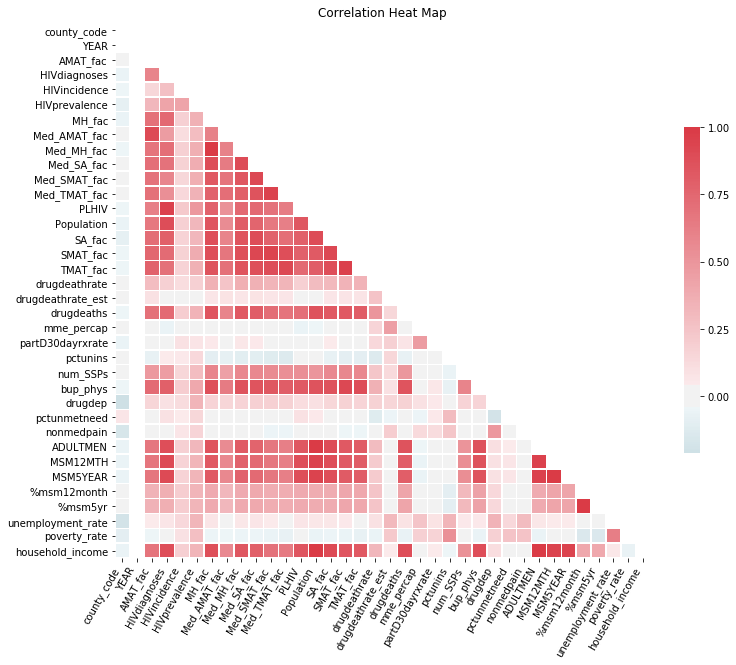

In [130]:

def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()
    
corr_heat(pd.DataFrame(df_main))

columns = ['county_code', 'COUNTY', 'STATEABBREVIATION', 'YEAR', 'AMAT_fac',
       'HIVdiagnoses', 'HIVprevalence', 'MH_fac',
       'Med_AMAT_fac', 'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac',
       'Med_TMAT_fac', 'PLHIV', 'Population', 'SA_fac', 'SMAT_fac', 'TMAT_fac',
       'drugdeathrate', 'drugdeathrate_est', 'drugdeaths', 'mme_percap',
       'partD30dayrxrate', 'pctunins', 'num_SSPs', 'bup_phys', 'drugdep',
       'pctunmetneed', 'nonmedpain', 'ADULTMEN', 'MSM12MTH', 'MSM5YEAR',
       '%msm12month', '%msm5yr', 'unemployment_rate', 'poverty_rate',
       'household_income']
       

# Basic Linear Regression
pre-cleaning, standardizing, ect.

In [131]:
linear = LinearRegression()

cleaned = df_main.dropna(axis=0, how='any')

X_train, X_test, y_train, y_test = train_test_split(cleaned[columns], cleaned['HIVincidence'], test_size=0.33, random_state=42)

#cleaned[columns].head()
#cleaned['HIVincidence'].head()

linear.fit(X_train, y_train)
                                                                              

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [132]:
X_train.describe()

,AMAT_fac,HIVdiagnoses,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,PLHIV,Population,SA_fac,SMAT_fac,TMAT_fac,drugdeathrate,mme_percap,partD30dayrxrate,pctunins,num_SSPs,bup_phys,drugdep,pctunmetneed,nonmedpain,ADULTMEN,%msm12month,unemployment_rate,poverty_rate,household_income
count,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1.967000e+03,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1.967000e+03,1967.000000,1967.000000,1967.000000,1.967000e+03
mean,0.096594,12.129131,148.232384,3.436706,0.065074,3.056940,2.388409,0.920183,0.480427,284.259786,1.098193e+05,3.980173,1.421962,0.783427,4.038180,703.332181,1.729248,13.146467,0.093035,7.963396,2.577468,88.680839,4.320081,3.941573e+04,1.311291,8.660803,16.796645,3.976260e+04
std,0.462009,62.135395,185.536004,8.188207,0.381190,7.159341,5.985369,2.901614,1.635845,1387.203558,3.056956e+05,11.197711,4.195488,2.490852,10.162042,458.884767,1.056491,5.098728,0.399628,24.587103,0.350682,3.235457,0.581089,1.070900e+05,0.918772,3.546903,6.437914,1.061814e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.215000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,2.200000,0.000000,0.000000,1.930000,77.020000,3.000000,4.210000e+02,0.475059,0.600000,3.800000,5.190000e+02
25%,0.000000,0.000000,44.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.323000e+04,0.000000,0.000000,0.000000,0.000000,403.250000,1.065000,9.300000,0.000000,0.000000,2.340000,86.480000,3.910000,5.115000e+03,0.566762,6.300000,12.200000,5.123500e+03
50%,0.000000,0.000000,95.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,25.000000,2.886200e+04,1.000000,0.000000,0.000000,0.000000,648.800000,1.570000,12.800000,0.000000,1.000000,2.550000,88.750000,4.320000,1.106700e+04,1.064903,8.400000,16.000000,1.114800e+04
75%,0.000000,5.000000,190.350000,3.000000,0.000000,3.000000,2.000000,1.000000,0.000000,101.000000,7.600500e+04,3.000000,1.000000,0.000000,0.000000,913.650000,2.185000,16.100000,0.000000,4.000000,2.790000,90.830000,4.700000,2.841050e+04,1.640434,10.700000,20.200000,2.898550e+04
max,6.000000,1256.000000,2445.400000,151.000000,5.000000,130.000000,125.000000,50.000000,24.000000,25623.000000,5.224823e+06,286.000000,78.000000,42.000000,108.300000,4086.900000,16.510000,42.500000,6.000000,327.000000,4.290000,97.980000,5.890000,1.905622e+06,8.144901,28.800000,45.800000,1.937060e+06


Min RMSE found: 24.07478682760067
Alpha used: none
Model Coef: [ -8.59845478e-01   2.23052997e-01   3.34546443e-02   3.81493954e-01
   7.96796918e-01  -1.97480020e-01   2.45315899e-01  -6.63434908e-01
   7.15748508e-02  -8.41188061e-03  -3.54679821e-05  -1.81242486e-01
   6.67099723e-01  -2.78270073e-01   5.31712064e-02  -8.97831200e-04
   7.77889862e-01   6.90466767e-02   6.31938663e-01   3.19168954e-02
  -1.00124124e+00   9.08056781e-02  -1.11958439e-02   1.10506442e-04
   4.57190759e-01   4.73883595e-02  -1.27271120e-01  -4.13893728e-05]


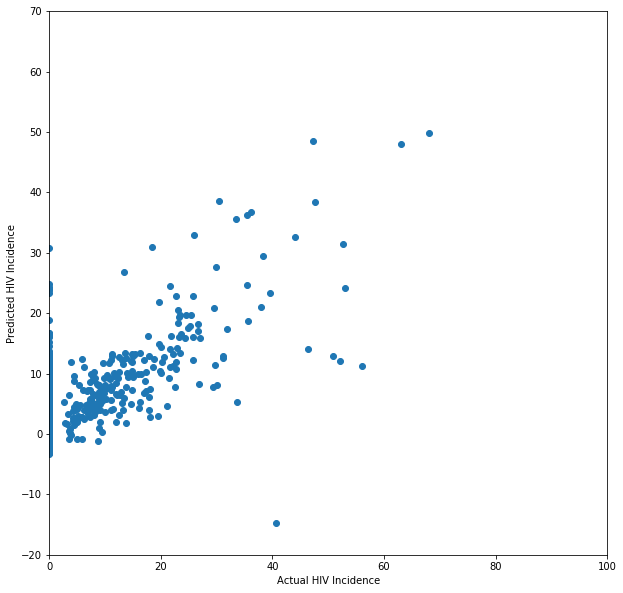

In [133]:
predicted_x_test = linear.predict(X_test)

print(f'Min RMSE found: {rmse(y_test.values, predicted_x_test)}')
print('Alpha used: none')
print(f'Model Coef: {linear.coef_}')

fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predicted_x_test)
plt.ylabel("Predicted HIV Incidence")
plt.xlabel("Actual HIV Incidence")
plt.xlim(0,100)
plt.ylim(-20,70)
plt.show()

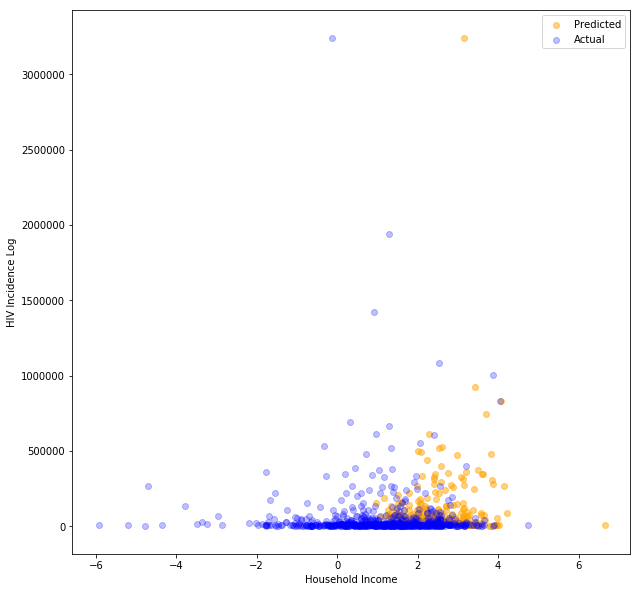

In [134]:
fig = plt.figure(figsize=(10,10))
plt.scatter(np.log(y_test), cleaned['household_income'][y_test.index],alpha = .5, color = 'orange', label="Predicted")
plt.scatter(np.log(predicted_x_test),cleaned['household_income'][0:len(predicted_x_test)],alpha = .25, color= 'blue', label = "Actual")
plt.ylabel("HIV Incidence Log")
plt.xlabel("Household Income")
#plt.xlim(0,100)
#plt.ylim(-20,70)
plt.legend()
plt.show()

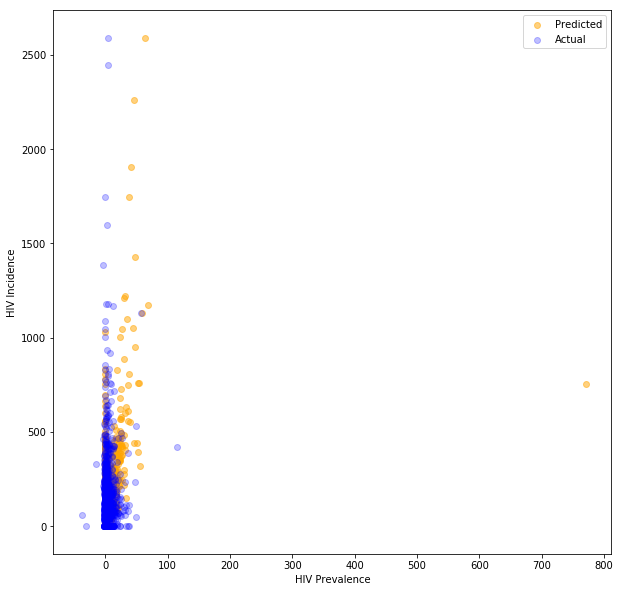

In [135]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, cleaned['HIVprevalence'][y_test.index],alpha = .5, color = 'orange', label="Predicted")
plt.scatter(predicted_x_test,cleaned['HIVprevalence'][0:len(predicted_x_test)],alpha = .25, color= 'blue', label = "Actual")
plt.ylabel("HIV Incidence")
plt.xlabel("HIV Prevalence")
#plt.xlim(0,100)
#plt.ylim(-20,70)
plt.legend()
plt.show()

# Data Pipelines

### Columns to drop
- In favor of %msm12month, drop:
    - MSM5YEAR
    - MSM12MNTH
    - %msm5year
- In favor of poverty_rate, drop unemployment_rate
- In favor of drugdeathrate, drop:
    - drugdeaths
    - drugdeathrate_est
- Because it's linearly related to incidence (the target), drop HIVdiagnoses
- In favor of prevalence, drop PLHIV (people living with HIV)
- Drop county_code, COUNTY because the records are grouped by county
- drop YEAR because this is all 2015
### Rows to drop
- Rows with NaN anywhere (~ about 200 rows)

In [136]:
df_main_predictors_raw = df_main.drop(['MSM5YEAR','MSM12MTH','%msm5yr','unemployment_rate','drugdeaths','drugdeathrate_est',
              'HIVdiagnoses','PLHIV','county_code','COUNTY','YEAR'], axis=1)
df_main_predictors_raw = df_main_predictors_raw.dropna(axis=0, how='any')
df_main_predictors_raw.columns
df_main_predictors_raw.shape

(2937, 27)

In [137]:
target = 'HIVincidence'


categorical_columns= 'STATEABBREVIATION'

raw_need_rate_conversion = ['AMAT_fac','MH_fac', 'Med_AMAT_fac', 'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac', 
                             'Med_TMAT_fac', 'SA_fac', 'SMAT_fac', 'TMAT_fac', 'num_SSPs','bup_phys','ADULTMEN']

rate_columns = ['HIVincidence','HIVprevalence','Population', 'drugdeathrate', 'mme_percap','partD30dayrxrate',
               'pctunins','drugdep','pctunmetneed','%msm12month', 'nonmedpain','poverty_rate','household_income'] 

In [138]:
class RateConversion(object):    
    '''takes raw numbers of things in county (like num of facilities) and divides by the population 
    (rate/person in county)'''
    def __init__(self):
        self
        
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, X, **transform_params):
        #print(X.info())
        X_rated = X.divide(X['Population'], axis=0)
        return X_rated

In [152]:
rate_conversion = RateConversion()
rate_conversion.fit(df_main_predictors_raw.drop("STATEABBREVIATION", axis = 1))
rate_conversion.transform(df_main_predictors_raw.drop("STATEABBREVIATION", axis = 1));

In [140]:
features_to_be_standardized = Pipeline([
    ('predictor_to_standardize', FeatureUnion([
        ('select_converted', Pipeline([
            #select the columns that need conversion to rate+pop, convert, and drop pop
            ('raw_need_rate_conversion', ColumnSelector(name=raw_need_rate_conversion+['Population'])),
            ('convert_em', RateConversion()),
            ('raw_rated', ColumnSelector(name=raw_need_rate_conversion))
        ])),
        ('select_rated',ColumnSelector(name=rate_columns)) #select the rate columns
        ])), 
    ('standardizer', StandardScaler())
])

In [155]:
features = features_to_be_standardized
features.fit(df_main_predictors_raw)
X = features.transform(df_main_predictors_raw)
Y = df_main_predictors_raw["HIVincidence"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)



## K-Fold with Ridge Modeling for Best Alpha

In [156]:
def rmse(y, y_hat):
    '''Write a function rmse(true, predicted) that takes your true and predicted values and calculates the RMSE. You should use sklearn.metrics.mean_squared_error() to confirm your results.
    '''
    mse = 0
    for i in range(len(y)):
        mse += (y[i]-y_hat[i])**2
    return np.sqrt(mse/len(y))

def cv(X, y, n_folds,alpha= 0.5):
    
    kfold = KFold(n_splits=n_folds, shuffle=True)
    kfold.get_n_splits(X)

    models = []
    rmse_scores = []

    for k_train_index, k_test_index in kfold.split(X):
        #Fit pipeline on k_train_indexs
      #  features.fit(X[k_train_index])
        #Transform x train and test
       # x_train_k = features.transform(X[k_train_index])
       # x_test_k = features.transform(X[k_test_index])
        
        
        x_train_k = X[k_train_index]
        x_test_k = X[k_test_index]
        y_train_k = y.values[k_train_index]
        y_test_k = y.values[k_test_index]
        
        # Fit ridge regression to training data.
        model = Ridge(alpha=alpha)
        model.fit(x_train_k, y_train_k)
        # Make predictions.
        y_predict = model.predict(x_test_k)
        # Calclate MSE & Record the MSE in a numpy array.
        models.append(model)
        rmse_scores.append(rmse(y_test_k, y_predict))
    return models[rmse_scores.index(min(rmse_scores))], min(rmse_scores)



model_list = []
rmse_list = []
alphas = []
for alpha in np.logspace(-2, 4, num=250):
    model_result, rmse_result = cv(X_train, y_train, 5, alpha)
    model_list.append(model_result)
    rmse_list.append(rmse_result)  
    alphas.append(alpha)


# Testing Final Model

Min RMSE found: 0.0002359372263558079
Alpha used: 0.01
Model Coef: [ -2.48694142e-06   5.02502531e-05  -1.28227071e-06  -5.81411880e-05
   7.61754741e-06  -9.12502909e-06  -1.19029192e-06   8.97170201e-06
   8.52494553e-06  -1.82446288e-06  -2.77691664e-07  -4.93535026e-06
  -5.58205802e-05   1.71002271e+01   2.59286108e-04  -3.54172184e-05
   1.22759801e-05  -1.48665096e-05   3.04246877e-05   3.07123246e-06
  -2.28837934e-05   4.71028815e-06   1.45343916e-05   9.75644939e-06
  -6.89788357e-06   6.55601171e-05]


Text(0.5,0,'Actual HIV Incidence')

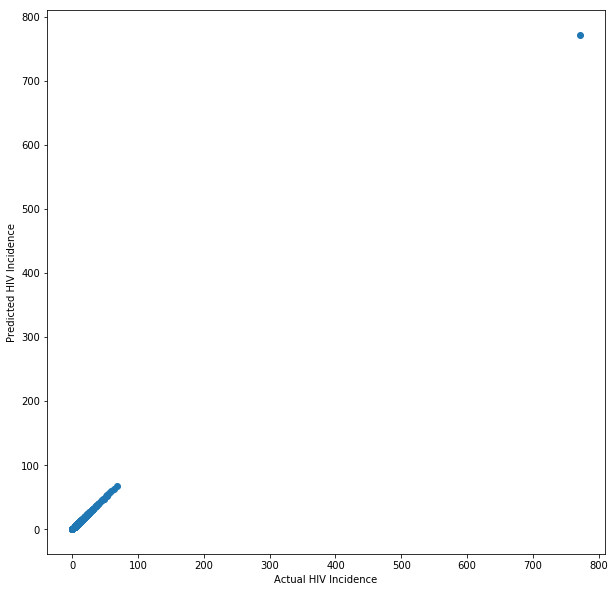

In [157]:
        
print(f'Min RMSE found: {min(rmse_list)}')
print(f'Alpha used: {alphas[rmse_list.index(min(rmse_list))]}')
print(f'Model Coef: {model_list[rmse_list.index(min(rmse_list))].coef_}')


#plot final predictions
predicted= model_list[rmse_list.index(min(rmse_list))].predict(X_test)

fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predicted)
plt.ylabel("Predicted HIV Incidence")
plt.xlabel("Actual HIV Incidence")
#plt.xlim(0,100)
#plt.ylim(-20,70)

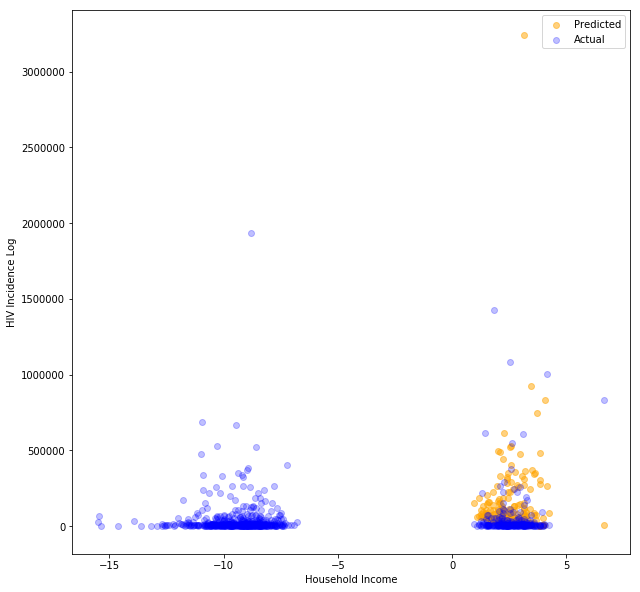

In [158]:
fig = plt.figure(figsize=(10,10))
plt.scatter(np.log(y_test), cleaned['household_income'][y_test.index],alpha = .5, color = 'orange', label="Predicted")
plt.scatter(np.log(predicted),cleaned['household_income'][0:len(predicted)],alpha = .25, color= 'blue', label = "Actual")
plt.ylabel("HIV Incidence Log")
plt.xlabel("Household Income")
#plt.xlim(0,100)
#plt.ylim(-20,70)
plt.legend()
plt.show()

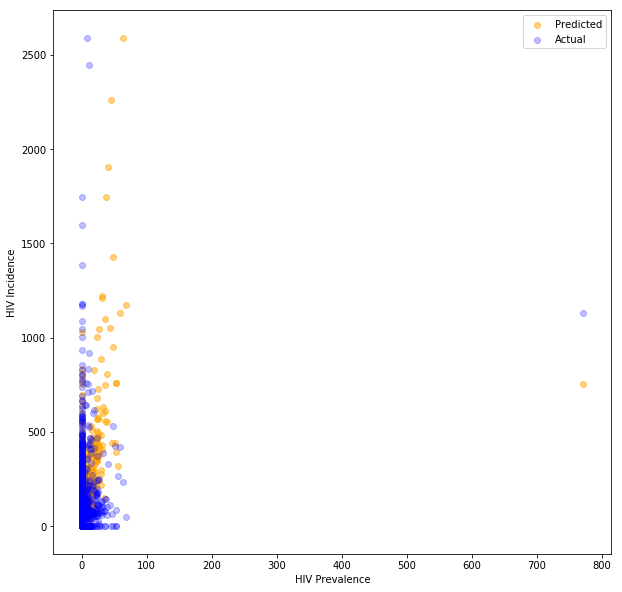

In [159]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, cleaned['HIVprevalence'][y_test.index],alpha = .5, color = 'orange', label="Predicted")
plt.scatter(predicted,cleaned['HIVprevalence'][0:len(predicted)],alpha = .25, color= 'blue', label = "Actual")
plt.ylabel("HIV Incidence")
plt.xlabel("HIV Prevalence")
#plt.xlim(0,100)
#plt.ylim(-20,70)
plt.legend()
plt.show()

# What we learned

- Data cleaning and EDA takes a lot of time
- When in doubt, try .values on everything
- Pipeline Debugging:
    - Be purposeful about what data you are passing in while testing
    - Test EVERYTHING as you go
    - Per Adam: you don't have to call the pipeline from within the k-fold
    - StandardScailer spits out a numpy array